In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import keras_tuner as kt

# Konstanta
TRAIN_DIR = 'Datasets/model1/training'
TEST_DIR = 'Datasets/model1/validation'
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_FOLDS = 5
EPOCHS_TUNING = 5
EPOCHS_TRAINING = 30

# Ambil nama kelas dari struktur direktori
class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
NUM_CLASSES = len(class_names)

# Kumpulkan path dan label
image_paths, labels = [], []
for cls in class_names:
    folder = os.path.join(TRAIN_DIR, cls)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(cls)

# Acak data
image_paths, labels = shuffle(image_paths, labels, random_state=42)
labels_np = np.array([class_names.index(l) for l in labels])

datagen = ImageDataGenerator(rescale=1./255)

2025-07-07 11:13:51.943143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751861631.958137   12809 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751861631.962318   12809 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-07 11:13:51.980195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trial 9 Complete [00h 02m 27s]
val_accuracy: 0.7274413108825684

Best val_accuracy So Far: 0.9690976738929749
Total elapsed time: 00h 21m 18s

📊 Hasil Tuning:
   dropout  learning_rate  val_accuracy
0      0.2        0.00100      0.969098
1      0.4        0.00100      0.962299
2      0.3        0.00100      0.953955
3      0.4        0.00010      0.858467
4      0.3        0.00010      0.852905
5      0.2        0.00010      0.835290
6      0.2        0.00005      0.792336
7      0.3        0.00005      0.772559
8      0.4        0.00005      0.727441


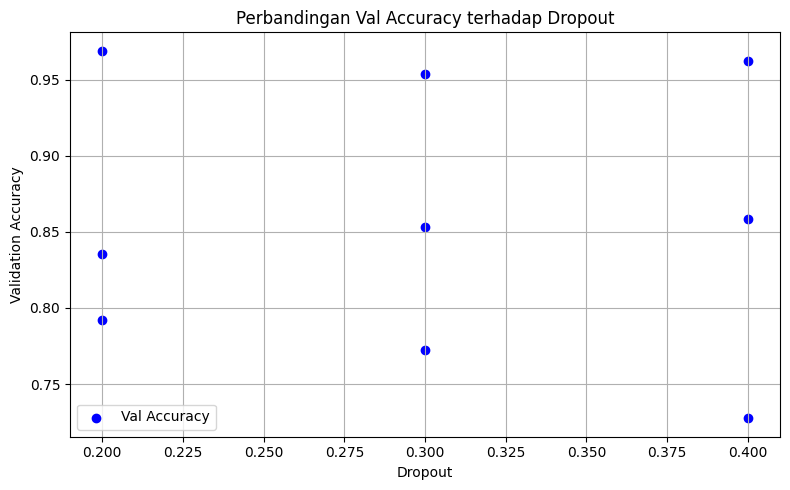

✅ Best Hyperparameters: learning_rate=0.001, dropout=0.2


In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras import layers, Model, regularizers
from sklearn.model_selection import StratifiedKFold

# ========== 1. Hyperparameter Tuning (Tanpa K-Fold, Sekali Saja) ==========

# Stratified KFold untuk tuning (1 fold saja)
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
for train_index, val_index in list(skf.split(image_paths, labels_np))[:1]:
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
train_gen = datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)
val_gen = datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)


def build_model(hp):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Unfreeze dari block 6 dan head
    for layer in base_model.layers[:163]:
        layer.trainable = False
    for layer in base_model.layers[163:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 5e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

NUM_TRIALS = 12
# Hyperparameter Tuning
print("\n🔍 Memulai hyperparameter tuning dengan StratifiedKFold (1 fold)...")
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=NUM_TRIALS,
    directory='tuner_dir',
    project_name='efficientnet_finetune_ensemble_test'
)

tuner.search(train_gen, validation_data=val_gen, epochs=EPOCHS_TUNING, callbacks=[EarlyStopping(patience=2)])

# Ambil semua hasil tuning
trials = tuner.oracle.get_best_trials(num_trials=NUM_TRIALS)
all_results = []
for trial in trials:
    all_results.append({
        'dropout': trial.hyperparameters.get('dropout'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'val_accuracy': trial.score
    })

# Tampilkan hasil tuning
print("\n📊 Hasil Tuning:")
tuning_df = pd.DataFrame(all_results)
print(tuning_df)

# Visualisasi hasil tuning
plt.figure(figsize=(8, 5))
plt.scatter(tuning_df['dropout'], tuning_df['val_accuracy'], c='blue', label='Val Accuracy')
plt.title("Perbandingan Val Accuracy terhadap Dropout")
plt.xlabel("Dropout")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"tuner_dir/efficientnet_finetune_ensemble_test/efficientnet_tuning_comparison.png")
plt.show()

best_hps = tuner.get_best_hyperparameters(1)[0]
best_lr = best_hps.get('learning_rate')
best_dropout = best_hps.get('dropout')

print(f"✅ Best Hyperparameters: learning_rate={best_lr}, dropout={best_dropout}")


In [3]:
# # Hyperparameter Tuning
# print("\n🔍 Memulai hyperparameter tuning dengan StratifiedKFold (1 fold)...")
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,
#     directory='tuner_dir',
#     project_name='efficientnet_finetune_block'
# )

# tuner.search(train_gen_tune, validation_data=val_gen_tune,
#              epochs=EPOCHS_TUNING, callbacks=[EarlyStopping(patience=2)])

# # Ambil semua hasil tuning
# trials = tuner.oracle.get_best_trials(num_trials=5)
# all_results = []
# for trial in trials:
#     all_results.append({
#         'dropout': trial.hyperparameters.get('dropout'),
#         'learning_rate': trial.hyperparameters.get('learning_rate'),
#         'val_accuracy': trial.score
#     })

# # Tampilkan hasil tuning
# print("\n📊 Hasil Tuning:")
# tuning_df = pd.DataFrame(all_results)
# print(tuning_df)

# # Visualisasi hasil tuning
# plt.figure(figsize=(8, 5))
# plt.scatter(tuning_df['dropout'], tuning_df['val_accuracy'], c='blue', label='Val Accuracy')
# plt.title("Perbandingan Val Accuracy terhadap Dropout")
# plt.xlabel("Dropout")
# plt.ylabel("Validation Accuracy")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("efficientnet_tuning_lr_dropout_tuning_comparison.png")
# plt.show()

# best_hps = tuner.get_best_hyperparameters(1)[0]
# best_lr = best_hps.get('learning_rate')
# best_dropout = best_hps.get('dropout')

# print(f"✅ Best Hyperparameters: learning_rate={best_lr}, dropout={best_dropout}")


In [4]:
from sklearn.model_selection import StratifiedKFold
# ========== 2. K-Fold Cross Validation ==========
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
labels_array = np.array(labels)

for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels_array)):
    print(f"\n=== Training Fold {fold+1} ===")

    train_df = pd.DataFrame({
        'filename': [image_paths[i] for i in train_idx],
        'class': [labels[i] for i in train_idx]
    })
    val_df = pd.DataFrame({
        'filename': [image_paths[i] for i in val_idx],
        'class': [labels[i] for i in val_idx]
    })

    train_gen = datagen.flow_from_dataframe(
        train_df, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True
    )
    val_gen = datagen.flow_from_dataframe(
        val_df, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    print(best_hps)
    model = build_model(best_hps)
    os.makedirs(f"saved_model_finetune/fold_{fold}/", exist_ok=True)

    acc_checkpoint = ModelCheckpoint(
        filepath=f"saved_model_finetune/fold_{fold}/best_accuracy_model.h5",
        monitor='val_accuracy', mode='max',
        save_best_only=True, verbose=1
    )
    loss_checkpoint = ModelCheckpoint(
        filepath=f"saved_model_finetune/fold_{fold}/best_loss_model.h5",
        monitor='val_loss', mode='min',
        save_best_only=True, verbose=1
    )
    earlystop = EarlyStopping(patience=5, restore_best_weights=True)

    history = model.fit(
        train_gen, validation_data=val_gen,
        epochs=EPOCHS_TRAINING,
        callbacks=[earlystop, acc_checkpoint, loss_checkpoint],
        verbose=1
    )

    # Visualisasi per fold
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(train_acc) + 1)

    # Grafik Akurasi
    plt.figure(figsize=(5, 5))
    plt.plot(epochs_range, train_acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')

    best_val_acc = max(val_acc)
    best_val_acc_epoch = val_acc.index(best_val_acc) + 1
    plt.scatter(best_val_acc_epoch, best_val_acc, color='red', label=f'Best Val Acc: {best_val_acc:.3f}')
    plt.text(best_val_acc_epoch, best_val_acc + 0.01, f'{best_val_acc:.3f}', ha='center', color='red')

    plt.title(f'Accuracy - Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'saved_model_finetune/fold_{fold}/accuracy.png')
    plt.close()

    # Grafik Loss
    plt.figure(figsize=(5, 5))
    plt.plot(epochs_range, train_loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')

    best_val_loss = min(val_loss)
    best_val_loss_epoch = val_loss.index(best_val_loss) + 1
    plt.scatter(best_val_loss_epoch, best_val_loss, color='green', label=f'Best Val Loss: {best_val_loss:.3f}')
    plt.text(best_val_loss_epoch, best_val_loss + 0.01, f'{best_val_loss:.3f}', ha='center', color='green')

    plt.title(f'Loss - Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'saved_model_finetune/fold_{fold}/loss.png')
    plt.close()


=== Training Fold 1 ===
Found 12943 validated image filenames belonging to 32 classes.
Found 3236 validated image filenames belonging to 32 classes.
Epoch 1/30


/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751033628.268929    1419 service.cc:148] XLA service 0x7f87cc004470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751033628.269146    1419 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-06-27 21:13:48.624068: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751033630.213605    1419 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-27 21:13:51.719713: I e

  1/405 ━━━━━━━━━━━━━━━━━━━━ 3:27:29 31s/step - accuracy: 0.0312 - loss: 3.5557

I0000 00:00:1751033647.962169    1419 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2745 - loss: 2.5617

2025-06-27 21:14:44.918215: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2074', 4 bytes spill stores, 4 bytes spill loads

2025-06-27 21:14:45.209190: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2074', 228 bytes spill stores, 228 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.48084, saving model to saved_model_finetune/fold_0/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 1.67828, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 81s 125ms/step - accuracy: 0.2757 - loss: 2.5573 - val_accuracy: 0.4808 - val_loss: 1.6783
Epoch 2/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8468 - loss: 0.4948
Epoch 2: val_accuracy improved from 0.48084 to 0.89617, saving model to saved_model_finetune/fold_0/best_accuracy_model.h5



Epoch 2: val_loss improved from 1.67828 to 0.30293, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.8469 - loss: 0.4945 - val_accuracy: 0.8962 - val_loss: 0.3029
Epoch 3/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9100 - loss: 0.2863
Epoch 3: val_accuracy improved from 0.89617 to 0.94036, saving model to saved_model_finetune/fold_0/best_accuracy_model.h5



Epoch 3: val_loss improved from 0.30293 to 0.18742, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9100 - loss: 0.2862 - val_accuracy: 0.9404 - val_loss: 0.1874
Epoch 4/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9337 - loss: 0.2083
Epoch 4: val_accuracy improved from 0.94036 to 0.94870, saving model to saved_model_finetune/fold_0/best_accuracy_model.h5



Epoch 4: val_loss improved from 0.18742 to 0.17823, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9337 - loss: 0.2083 - val_accuracy: 0.9487 - val_loss: 0.1782
Epoch 5/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9463 - loss: 0.1711
Epoch 5: val_accuracy did not improve from 0.94870

Epoch 5: val_loss did not improve from 0.17823
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9463 - loss: 0.1711 - val_accuracy: 0.9169 - val_loss: 0.3031
Epoch 6/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9581 - loss: 0.1386
Epoch 6: val_accuracy improved from 0.94870 to 0.96415, saving model to saved_model_finetune/fold_0/best_accuracy_model.h5



Epoch 6: val_loss improved from 0.17823 to 0.14072, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9581 - loss: 0.1386 - val_accuracy: 0.9642 - val_loss: 0.1407
Epoch 7/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9631 - loss: 0.1307
Epoch 7: val_accuracy did not improve from 0.96415

Epoch 7: val_loss improved from 0.14072 to 0.13329, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9631 - loss: 0.1307 - val_accuracy: 0.9623 - val_loss: 0.1333
Epoch 8/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9627 - loss: 0.1193
Epoch 8: val_accuracy did not improve from 0.96415

Epoch 8: val_loss did not improve from 0.13329
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9627 - loss: 0.1193 - val_accuracy: 0.9567 - val_loss: 0.1488
Epoch 9/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9720 - loss: 0.0940
Epoch 9: val_accuracy improved from 0.96415 to 0.97528, saving model to saved_model_finetune/fold_0/best_accuracy_model.h5



Epoch 9: val_loss improved from 0.13329 to 0.10218, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9720 - loss: 0.0940 - val_accuracy: 0.9753 - val_loss: 0.1022
Epoch 10/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9772 - loss: 0.0821
Epoch 10: val_accuracy did not improve from 0.97528

Epoch 10: val_loss did not improve from 0.10218
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9772 - loss: 0.0821 - val_accuracy: 0.9750 - val_loss: 0.1033
Epoch 11/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9759 - loss: 0.0879
Epoch 11: val_accuracy improved from 0.97528 to 0.97713, saving model to saved_model_finetune/fold_0/best_accuracy_model.h5



Epoch 11: val_loss improved from 0.10218 to 0.09015, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9759 - loss: 0.0879 - val_accuracy: 0.9771 - val_loss: 0.0901
Epoch 12/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9756 - loss: 0.0797
Epoch 12: val_accuracy did not improve from 0.97713

Epoch 12: val_loss did not improve from 0.09015
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9756 - loss: 0.0797 - val_accuracy: 0.9753 - val_loss: 0.0971
Epoch 13/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9773 - loss: 0.0709
Epoch 13: val_accuracy did not improve from 0.97713

Epoch 13: val_loss did not improve from 0.09015
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9773 - loss: 0.0709 - val_accuracy: 0.9771 - val_loss: 0.0949
Epoch 14/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9827 - loss: 0.0588
Epoch 14: val_accuracy did not improve from 0.97713

Epoch 14: val_loss did not improve from 0.09015
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9827 - loss: 0.0589


Epoch 16: val_loss improved from 0.09015 to 0.08877, saving model to saved_model_finetune/fold_0/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9855 - loss: 0.0465 - val_accuracy: 0.9784 - val_loss: 0.0888
Epoch 17/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9818 - loss: 0.0562
Epoch 17: val_accuracy did not improve from 0.97837

Epoch 17: val_loss did not improve from 0.08877
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9818 - loss: 0.0562 - val_accuracy: 0.9713 - val_loss: 0.1061
Epoch 18/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9841 - loss: 0.0561
Epoch 18: val_accuracy improved from 0.97837 to 0.97899, saving model to saved_model_finetune/fold_0/best_accuracy_model.h5



Epoch 18: val_loss did not improve from 0.08877
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9841 - loss: 0.0561 - val_accuracy: 0.9790 - val_loss: 0.0924
Epoch 19/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9824 - loss: 0.0539
Epoch 19: val_accuracy did not improve from 0.97899

Epoch 19: val_loss did not improve from 0.08877
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9824 - loss: 0.0539 - val_accuracy: 0.9740 - val_loss: 0.1194
Epoch 20/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9849 - loss: 0.0498
Epoch 20: val_accuracy did not improve from 0.97899

Epoch 20: val_loss did not improve from 0.08877
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9849 - loss: 0.0498 - val_accuracy: 0.9694 - val_loss: 0.1257
Epoch 21/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9867 - loss: 0.0445
Epoch 21: val_accuracy did not improve from 0.97899

Epoch 21: val_loss did not improve from 0.08877
405/405 ━━━━━━━━━━━━━━━━━━━

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3019 - loss: 2.4485
Epoch 1: val_accuracy improved from -inf to 0.71230, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 0.88529, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 60s 91ms/step - accuracy: 0.3032 - loss: 2.4439 - val_accuracy: 0.7123 - val_loss: 0.8853
Epoch 2/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8620 - loss: 0.4530
Epoch 2: val_accuracy improved from 0.71230 to 0.92800, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 2: val_loss improved from 0.88529 to 0.23464, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8621 - loss: 0.4528 - val_accuracy: 0.9280 - val_loss: 0.2346
Epoch 3/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9143 - loss: 0.2567
Epoch 3: val_accuracy improved from 0.92800 to 0.94468, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 3: val_loss improved from 0.23464 to 0.19778, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9143 - loss: 0.2566 - val_accuracy: 0.9447 - val_loss: 0.1978
Epoch 4/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9433 - loss: 0.1927
Epoch 4: val_accuracy did not improve from 0.94468

Epoch 4: val_loss did not improve from 0.19778
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9433 - loss: 0.1927 - val_accuracy: 0.9391 - val_loss: 0.2090
Epoch 5/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9494 - loss: 0.1615
Epoch 5: val_accuracy improved from 0.94468 to 0.95828, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 5: val_loss improved from 0.19778 to 0.16307, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9494 - loss: 0.1614 - val_accuracy: 0.9583 - val_loss: 0.1631
Epoch 6/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9581 - loss: 0.1366
Epoch 6: val_accuracy improved from 0.95828 to 0.96137, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 6: val_loss improved from 0.16307 to 0.14745, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9580 - loss: 0.1366 - val_accuracy: 0.9614 - val_loss: 0.1475
Epoch 7/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9648 - loss: 0.1148
Epoch 7: val_accuracy improved from 0.96137 to 0.96755, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 7: val_loss did not improve from 0.14745
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9648 - loss: 0.1148 - val_accuracy: 0.9676 - val_loss: 0.1513
Epoch 8/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9717 - loss: 0.0965
Epoch 8: val_accuracy did not improve from 0.96755

Epoch 8: val_loss improved from 0.14745 to 0.14253, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9717 - loss: 0.0965 - val_accuracy: 0.9648 - val_loss: 0.1425
Epoch 9/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9752 - loss: 0.0786
Epoch 9: val_accuracy improved from 0.96755 to 0.97404, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 9: val_loss improved from 0.14253 to 0.14245, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9752 - loss: 0.0786 - val_accuracy: 0.9740 - val_loss: 0.1425
Epoch 10/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9718 - loss: 0.0900
Epoch 10: val_accuracy did not improve from 0.97404

Epoch 10: val_loss did not improve from 0.14245
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9718 - loss: 0.0900 - val_accuracy: 0.9648 - val_loss: 0.1653
Epoch 11/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9746 - loss: 0.0795
Epoch 11: val_accuracy did not improve from 0.97404

Epoch 11: val_loss did not improve from 0.14245
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9746 - loss: 0.0795 - val_accuracy: 0.9527 - val_loss: 0.1875
Epoch 12/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9697 - loss: 0.0949
Epoch 12: val_accuracy improved from 0.97404 to 0.97775, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 12: val_loss improved from 0.14245 to 0.12857, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9697 - loss: 0.0948 - val_accuracy: 0.9778 - val_loss: 0.1286
Epoch 13/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9800 - loss: 0.0634
Epoch 13: val_accuracy did not improve from 0.97775

Epoch 13: val_loss did not improve from 0.12857
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9800 - loss: 0.0634 - val_accuracy: 0.9744 - val_loss: 0.1470
Epoch 14/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9784 - loss: 0.0658
Epoch 14: val_accuracy improved from 0.97775 to 0.97837, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 14: val_loss improved from 0.12857 to 0.12074, saving model to saved_model_finetune/fold_1/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9784 - loss: 0.0658 - val_accuracy: 0.9784 - val_loss: 0.1207
Epoch 15/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9785 - loss: 0.0614
Epoch 15: val_accuracy did not improve from 0.97837

Epoch 15: val_loss did not improve from 0.12074
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9785 - loss: 0.0614 - val_accuracy: 0.9747 - val_loss: 0.1363
Epoch 16/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9801 - loss: 0.0595
Epoch 16: val_accuracy improved from 0.97837 to 0.97868, saving model to saved_model_finetune/fold_1/best_accuracy_model.h5



Epoch 16: val_loss did not improve from 0.12074
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9801 - loss: 0.0595 - val_accuracy: 0.9787 - val_loss: 0.1255
Epoch 17/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9878 - loss: 0.0432
Epoch 17: val_accuracy did not improve from 0.97868

Epoch 17: val_loss did not improve from 0.12074
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9878 - loss: 0.0432 - val_accuracy: 0.9697 - val_loss: 0.1851
Epoch 18/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9842 - loss: 0.0556
Epoch 18: val_accuracy did not improve from 0.97868

Epoch 18: val_loss did not improve from 0.12074
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9842 - loss: 0.0556 - val_accuracy: 0.9768 - val_loss: 0.1389
Epoch 19/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9875 - loss: 0.0428
Epoch 19: val_accuracy did not improve from 0.97868

Epoch 19: val_loss did not improve from 0.12074
405/405 ━━━━━━━━━━━━━━━━━━━

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2824 - loss: 2.5387
Epoch 1: val_accuracy improved from -inf to 0.57818, saving model to saved_model_finetune/fold_2/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 1.36922, saving model to saved_model_finetune/fold_2/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 64s 99ms/step - accuracy: 0.2830 - loss: 2.5365 - val_accuracy: 0.5782 - val_loss: 1.3692
Epoch 2/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8479 - loss: 0.5113
Epoch 2: val_accuracy improved from 0.57818 to 0.93201, saving model to saved_model_finetune/fold_2/best_accuracy_model.h5



Epoch 2: val_loss improved from 1.36922 to 0.21712, saving model to saved_model_finetune/fold_2/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.8480 - loss: 0.5109 - val_accuracy: 0.9320 - val_loss: 0.2171
Epoch 3/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9114 - loss: 0.2893
Epoch 3: val_accuracy improved from 0.93201 to 0.95797, saving model to saved_model_finetune/fold_2/best_accuracy_model.h5



Epoch 3: val_loss improved from 0.21712 to 0.16062, saving model to saved_model_finetune/fold_2/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9115 - loss: 0.2893 - val_accuracy: 0.9580 - val_loss: 0.1606
Epoch 4/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9368 - loss: 0.2135
Epoch 4: val_accuracy did not improve from 0.95797

Epoch 4: val_loss did not improve from 0.16062
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9368 - loss: 0.2135 - val_accuracy: 0.9258 - val_loss: 0.2352
Epoch 5/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9480 - loss: 0.1739
Epoch 5: val_accuracy did not improve from 0.95797

Epoch 5: val_loss did not improve from 0.16062
405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.9480 - loss: 0.1739 - val_accuracy: 0.9456 - val_loss: 0.1838
Epoch 6/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9576 - loss: 0.1369
Epoch 6: val_accuracy improved from 0.95797 to 0.96539, saving model to saved_model_finetune/fold_2/best_accuracy_model.h5



Epoch 6: val_loss improved from 0.16062 to 0.12123, saving model to saved_model_finetune/fold_2/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.9576 - loss: 0.1370 - val_accuracy: 0.9654 - val_loss: 0.1212
Epoch 7/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9622 - loss: 0.1212
Epoch 7: val_accuracy did not improve from 0.96539

Epoch 7: val_loss did not improve from 0.12123
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9622 - loss: 0.1212 - val_accuracy: 0.9654 - val_loss: 0.1227
Epoch 8/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9628 - loss: 0.1186
Epoch 8: val_accuracy improved from 0.96539 to 0.97002, saving model to saved_model_finetune/fold_2/best_accuracy_model.h5



Epoch 8: val_loss improved from 0.12123 to 0.10122, saving model to saved_model_finetune/fold_2/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9628 - loss: 0.1187 - val_accuracy: 0.9700 - val_loss: 0.1012
Epoch 9/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9720 - loss: 0.0980
Epoch 9: val_accuracy did not improve from 0.97002

Epoch 9: val_loss did not improve from 0.10122
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9720 - loss: 0.0981 - val_accuracy: 0.9549 - val_loss: 0.1582
Epoch 10/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9700 - loss: 0.1046
Epoch 10: val_accuracy did not improve from 0.97002

Epoch 10: val_loss did not improve from 0.10122
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9700 - loss: 0.1046 - val_accuracy: 0.9632 - val_loss: 0.1160
Epoch 11/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9758 - loss: 0.0774
Epoch 11: val_accuracy did not improve from 0.97002

Epoch 11: val_loss did not improve from 0.10122
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9758 - loss: 0.0774 - 

/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3102 - loss: 2.4325
Epoch 1: val_accuracy improved from -inf to 0.36650, saving model to saved_model_finetune/fold_3/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 3.10841, saving model to saved_model_finetune/fold_3/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - accuracy: 0.3113 - loss: 2.4283 - val_accuracy: 0.3665 - val_loss: 3.1084
Epoch 2/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8495 - loss: 0.5030
Epoch 2: val_accuracy improved from 0.36650 to 0.90977, saving model to saved_model_finetune/fold_3/best_accuracy_model.h5



Epoch 2: val_loss improved from 3.10841 to 0.29319, saving model to saved_model_finetune/fold_3/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.8495 - loss: 0.5028 - val_accuracy: 0.9098 - val_loss: 0.2932
Epoch 3/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9120 - loss: 0.2905
Epoch 3: val_accuracy improved from 0.90977 to 0.93201, saving model to saved_model_finetune/fold_3/best_accuracy_model.h5



Epoch 3: val_loss improved from 0.29319 to 0.26823, saving model to saved_model_finetune/fold_3/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.9121 - loss: 0.2904 - val_accuracy: 0.9320 - val_loss: 0.2682
Epoch 4/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9336 - loss: 0.2183
Epoch 4: val_accuracy improved from 0.93201 to 0.95457, saving model to saved_model_finetune/fold_3/best_accuracy_model.h5



Epoch 4: val_loss improved from 0.26823 to 0.15122, saving model to saved_model_finetune/fold_3/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9336 - loss: 0.2183 - val_accuracy: 0.9546 - val_loss: 0.1512
Epoch 5/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9498 - loss: 0.1660
Epoch 5: val_accuracy improved from 0.95457 to 0.96539, saving model to saved_model_finetune/fold_3/best_accuracy_model.h5



Epoch 5: val_loss improved from 0.15122 to 0.13056, saving model to saved_model_finetune/fold_3/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9498 - loss: 0.1661 - val_accuracy: 0.9654 - val_loss: 0.1306
Epoch 6/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9592 - loss: 0.1299
Epoch 6: val_accuracy did not improve from 0.96539

Epoch 6: val_loss did not improve from 0.13056
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9592 - loss: 0.1299 - val_accuracy: 0.9536 - val_loss: 0.1642
Epoch 7/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9654 - loss: 0.1213
Epoch 7: val_accuracy did not improve from 0.96539

Epoch 7: val_loss did not improve from 0.13056
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9654 - loss: 0.1213 - val_accuracy: 0.9546 - val_loss: 0.1623
Epoch 8/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9679 - loss: 0.1049
Epoch 8: val_accuracy did not improve from 0.96539

Epoch 8: val_loss did not improve from 0.13056
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9679 - loss: 0.1049 - val_ac


Epoch 10: val_loss improved from 0.13056 to 0.12324, saving model to saved_model_finetune/fold_3/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9671 - loss: 0.1098 - val_accuracy: 0.9666 - val_loss: 0.1232
Epoch 11/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9739 - loss: 0.0789
Epoch 11: val_accuracy did not improve from 0.96663

Epoch 11: val_loss did not improve from 0.12324
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9739 - loss: 0.0789 - val_accuracy: 0.9329 - val_loss: 0.2356
Epoch 12/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9770 - loss: 0.0769
Epoch 12: val_accuracy did not improve from 0.96663

Epoch 12: val_loss did not improve from 0.12324
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9770 - loss: 0.0769 - val_accuracy: 0.9586 - val_loss: 0.1579
Epoch 13/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9781 - loss: 0.0766
Epoch 13: val_accuracy did not improve from 0.96663

Epoch 13: val_loss did not improve from 0.12324
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9781 - loss: 0.0766


Epoch 14: val_loss improved from 0.12324 to 0.09443, saving model to saved_model_finetune/fold_3/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9800 - loss: 0.0698 - val_accuracy: 0.9759 - val_loss: 0.0944
Epoch 15/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9816 - loss: 0.0586
Epoch 15: val_accuracy did not improve from 0.97590

Epoch 15: val_loss did not improve from 0.09443
405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.9816 - loss: 0.0586 - val_accuracy: 0.9744 - val_loss: 0.1158
Epoch 16/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9805 - loss: 0.0636
Epoch 16: val_accuracy did not improve from 0.97590

Epoch 16: val_loss did not improve from 0.09443
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9805 - loss: 0.0636 - val_accuracy: 0.9737 - val_loss: 0.0993
Epoch 17/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9841 - loss: 0.0492
Epoch 17: val_accuracy did not improve from 0.97590

Epoch 17: val_loss did not improve from 0.09443
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9841 - loss: 0.0492


Epoch 19: val_loss did not improve from 0.09443
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9838 - loss: 0.0476 - val_accuracy: 0.9771 - val_loss: 0.1005

=== Training Fold 5 ===
Found 12944 validated image filenames belonging to 32 classes.
Found 3235 validated image filenames belonging to 32 classes.
Epoch 1/30


/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3072 - loss: 2.4396
Epoch 1: val_accuracy improved from -inf to 0.71314, saving model to saved_model_finetune/fold_4/best_accuracy_model.h5



Epoch 1: val_loss improved from inf to 0.87015, saving model to saved_model_finetune/fold_4/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 72s 120ms/step - accuracy: 0.3077 - loss: 2.4375 - val_accuracy: 0.7131 - val_loss: 0.8702
Epoch 2/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8536 - loss: 0.4689
Epoch 2: val_accuracy improved from 0.71314 to 0.89675, saving model to saved_model_finetune/fold_4/best_accuracy_model.h5



Epoch 2: val_loss improved from 0.87015 to 0.31188, saving model to saved_model_finetune/fold_4/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.8536 - loss: 0.4687 - val_accuracy: 0.8968 - val_loss: 0.3119
Epoch 3/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9172 - loss: 0.2861
Epoch 3: val_accuracy did not improve from 0.89675

Epoch 3: val_loss did not improve from 0.31188
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9172 - loss: 0.2859 - val_accuracy: 0.8896 - val_loss: 0.3564
Epoch 4/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9391 - loss: 0.1979
Epoch 4: val_accuracy improved from 0.89675 to 0.93849, saving model to saved_model_finetune/fold_4/best_accuracy_model.h5



Epoch 4: val_loss improved from 0.31188 to 0.20352, saving model to saved_model_finetune/fold_4/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9391 - loss: 0.1979 - val_accuracy: 0.9385 - val_loss: 0.2035
Epoch 5/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9474 - loss: 0.1691
Epoch 5: val_accuracy improved from 0.93849 to 0.94250, saving model to saved_model_finetune/fold_4/best_accuracy_model.h5



Epoch 5: val_loss improved from 0.20352 to 0.18470, saving model to saved_model_finetune/fold_4/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.9474 - loss: 0.1691 - val_accuracy: 0.9425 - val_loss: 0.1847
Epoch 6/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9605 - loss: 0.1330
Epoch 6: val_accuracy improved from 0.94250 to 0.96414, saving model to saved_model_finetune/fold_4/best_accuracy_model.h5



Epoch 6: val_loss improved from 0.18470 to 0.13290, saving model to saved_model_finetune/fold_4/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9605 - loss: 0.1330 - val_accuracy: 0.9641 - val_loss: 0.1329
Epoch 7/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9654 - loss: 0.1129
Epoch 7: val_accuracy improved from 0.96414 to 0.97280, saving model to saved_model_finetune/fold_4/best_accuracy_model.h5



Epoch 7: val_loss improved from 0.13290 to 0.10434, saving model to saved_model_finetune/fold_4/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9654 - loss: 0.1129 - val_accuracy: 0.9728 - val_loss: 0.1043
Epoch 8/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9640 - loss: 0.1151
Epoch 8: val_accuracy did not improve from 0.97280

Epoch 8: val_loss did not improve from 0.10434
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9640 - loss: 0.1151 - val_accuracy: 0.9635 - val_loss: 0.1426
Epoch 9/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9689 - loss: 0.1021
Epoch 9: val_accuracy did not improve from 0.97280

Epoch 9: val_loss did not improve from 0.10434
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9689 - loss: 0.1021 - val_accuracy: 0.9583 - val_loss: 0.1509
Epoch 10/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9723 - loss: 0.0859
Epoch 10: val_accuracy improved from 0.97280 to 0.97342, saving model to saved_model_finetune/fold_4/best_accuracy_model.h5



Epoch 10: val_loss improved from 0.10434 to 0.09994, saving model to saved_model_finetune/fold_4/best_loss_model.h5


405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9723 - loss: 0.0860 - val_accuracy: 0.9734 - val_loss: 0.0999
Epoch 11/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9770 - loss: 0.0834
Epoch 11: val_accuracy did not improve from 0.97342

Epoch 11: val_loss did not improve from 0.09994
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9770 - loss: 0.0834 - val_accuracy: 0.9629 - val_loss: 0.1395
Epoch 12/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9752 - loss: 0.0776
Epoch 12: val_accuracy improved from 0.97342 to 0.97403, saving model to saved_model_finetune/fold_4/best_accuracy_model.h5



Epoch 12: val_loss did not improve from 0.09994
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9752 - loss: 0.0776 - val_accuracy: 0.9740 - val_loss: 0.1107
Epoch 13/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9791 - loss: 0.0710
Epoch 13: val_accuracy did not improve from 0.97403

Epoch 13: val_loss did not improve from 0.09994
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9791 - loss: 0.0711 - val_accuracy: 0.9641 - val_loss: 0.1248
Epoch 14/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9783 - loss: 0.0624
Epoch 14: val_accuracy did not improve from 0.97403

Epoch 14: val_loss did not improve from 0.09994
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9783 - loss: 0.0624 - val_accuracy: 0.9666 - val_loss: 0.1340
Epoch 15/30
404/405 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9823 - loss: 0.0589
Epoch 15: val_accuracy did not improve from 0.97403

Epoch 15: val_loss did not improve from 0.09994
405/405 ━━━━━━━━━━━━━━━━━━━

2025-07-07 10:46:58.518368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751860018.530709    1027 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751860018.535577    1027 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-07 10:46:58.552751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4045 images belonging to 32 classes.

Evaluating Fold 0 - accuracy model...


I0000 00:00:1751860021.367738    1027 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751860030.730715    7368 service.cc:148] XLA service 0x7f6898003ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751860030.730751    7368 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-07-07 10:47:10.812653: I tensorflow/compiler/mlir/tensorfl

  5/127 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step 

I0000 00:00:1751860039.745523    7368 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step
F1-Score: 0.9785
              precision    recall  f1-score   support

           a       0.86      0.98      0.91       126
          ba       0.99      0.99      0.99       127
          ca       0.99      0.99      0.99       125
          da       0.99      0.98      0.99       125
           e       1.00      0.94      0.97       125
          eu       0.98      0.98      0.98       125
          fa       0.95      0.98      0.97       126
          ga       0.96      0.98      0.97       126
          ha       0.98      0.99      0.99       125
           i       0.98      0.99      0.98       125
          ja       0.98      1.00      0.99       125
          ka       1.00      0.98      0.99       126
         kha       0.99      0.99      0.99       125
          la       0.95      0.98      0.96       125
          ma       1.00      0.98      0.99       125
          na       0.98      1.00      0.99       125
         nga       0

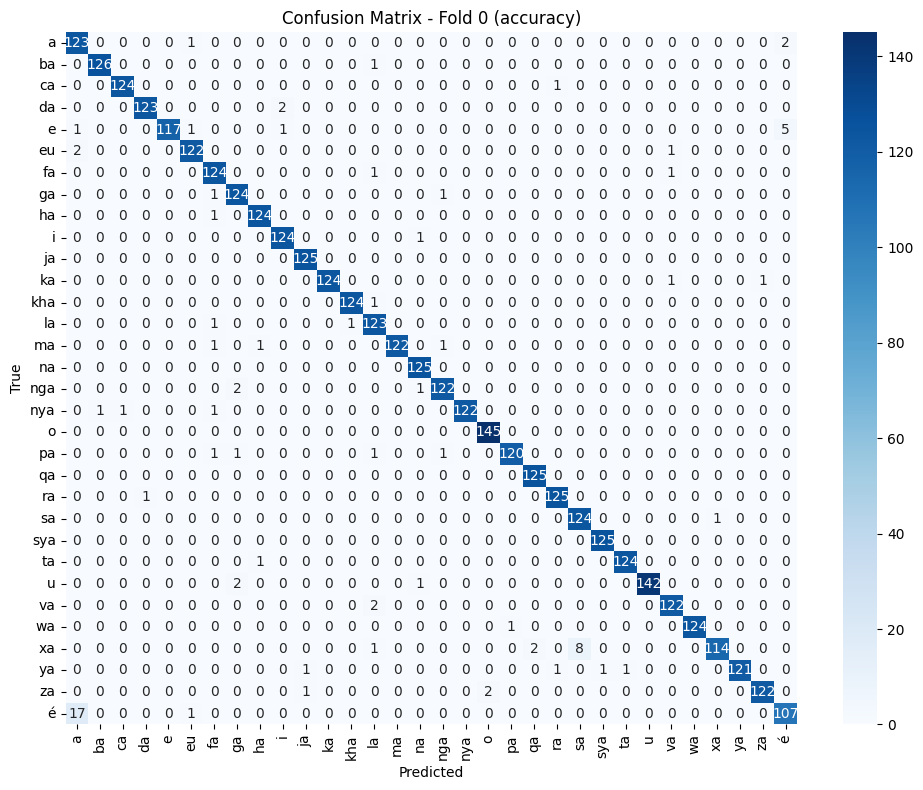


Evaluating Fold 1 - accuracy model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step
F1-Score: 0.9760
              precision    recall  f1-score   support

           a       0.91      0.94      0.93       126
          ba       0.99      0.99      0.99       127
          ca       0.99      0.99      0.99       125
          da       0.98      0.97      0.98       125
           e       0.98      0.98      0.98       125
          eu       0.98      0.97      0.97       125
          fa       0.97      0.98      0.97       126
          ga       0.97      0.94      0.96       126
          ha       0.99      1.00      1.00       125
           i       0.90      0.98      0.94       125
          ja       0.97      1.00      0.98       125
          ka       0.99      0.99      0.99       126
         kha       0.98      0.99      0.99       125
          la       0.99      0.98      0.98       125
          ma       1.00      0.99      1.00       125
          na       0.98      1.00      0.99       125
         nga       0.

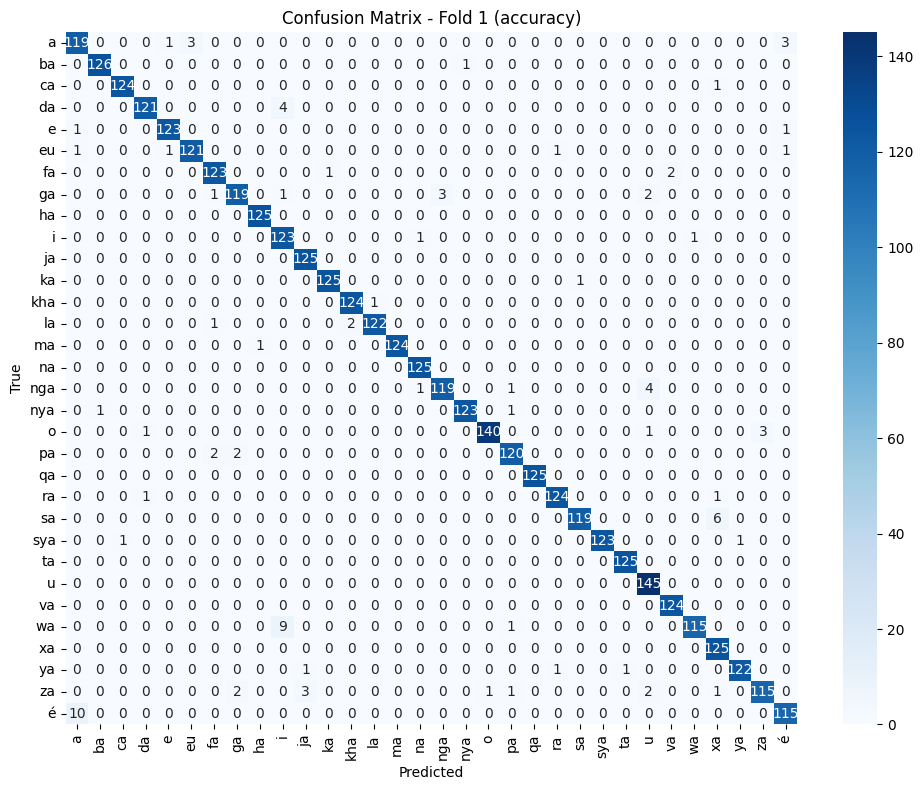


Evaluating Fold 2 - accuracy model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step
F1-Score: 0.9708
              precision    recall  f1-score   support

           a       0.94      0.72      0.82       126
          ba       0.99      0.98      0.99       127
          ca       1.00      0.99      1.00       125
          da       0.99      0.98      0.98       125
           e       0.97      0.99      0.98       125
          eu       0.98      0.94      0.96       125
          fa       0.89      0.98      0.94       126
          ga       0.99      0.96      0.98       126
          ha       0.98      0.99      0.99       125
           i       0.96      0.98      0.97       125
          ja       0.98      0.99      0.99       125
          ka       0.98      1.00      0.99       126
         kha       0.99      0.98      0.99       125
          la       0.99      0.92      0.95       125
          ma       1.00      0.95      0.98       125
          na       0.96      1.00      0.98       125
         nga       0.

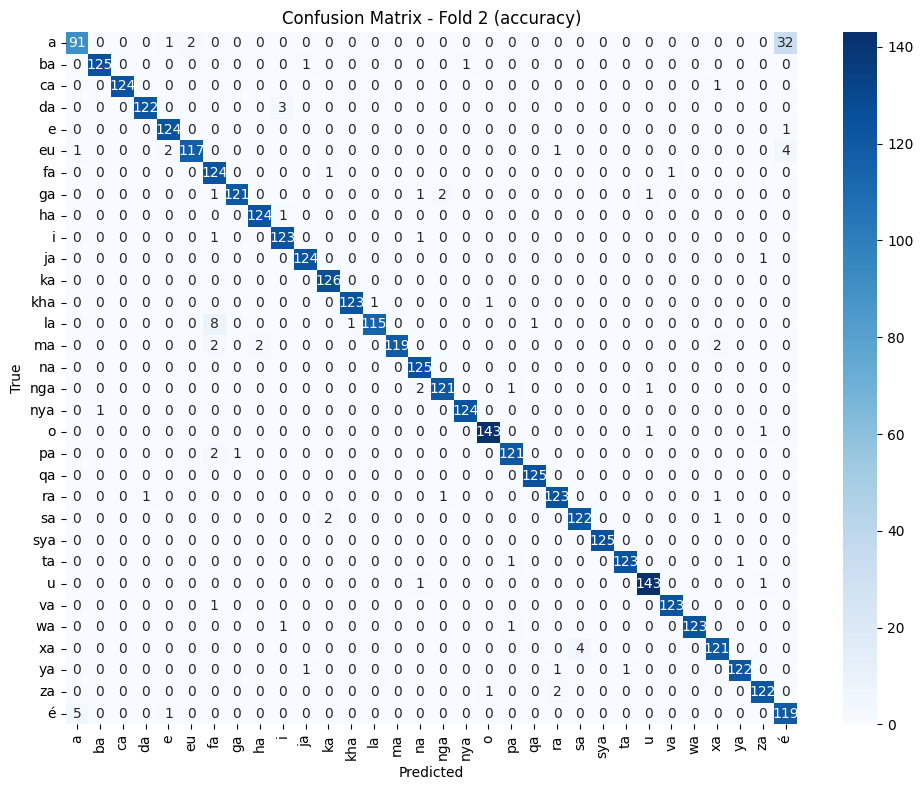


Evaluating Fold 3 - accuracy model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step
F1-Score: 0.9748
              precision    recall  f1-score   support

           a       0.91      0.92      0.91       126
          ba       0.98      0.98      0.98       127
          ca       1.00      1.00      1.00       125
          da       0.99      1.00      1.00       125
           e       0.96      0.98      0.97       125
          eu       0.99      0.95      0.97       125
          fa       0.94      0.92      0.93       126
          ga       0.98      0.96      0.97       126
          ha       0.98      0.99      0.98       125
           i       0.98      0.98      0.98       125
          ja       0.98      1.00      0.99       125
          ka       0.98      0.98      0.98       126
         kha       0.98      0.98      0.98       125
          la       0.98      0.95      0.97       125
          ma       1.00      0.96      0.98       125
          na       0.99      1.00      1.00       125
         nga       0.

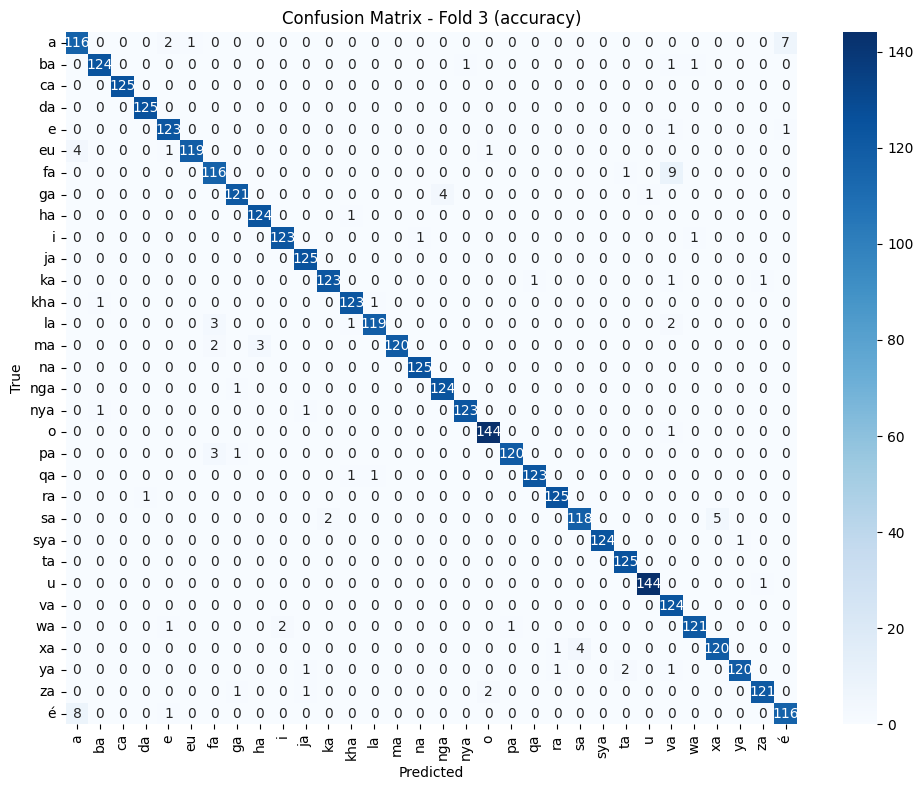


Evaluating Fold 4 - accuracy model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step
F1-Score: 0.9729
              precision    recall  f1-score   support

           a       0.89      0.92      0.91       126
          ba       0.98      1.00      0.99       127
          ca       1.00      1.00      1.00       125
          da       0.99      0.98      0.98       125
           e       0.97      0.99      0.98       125
          eu       0.89      0.99      0.94       125
          fa       0.98      0.95      0.97       126
          ga       0.86      0.99      0.92       126
          ha       0.98      1.00      0.99       125
           i       0.98      0.91      0.95       125
          ja       0.98      0.99      0.98       125
          ka       0.99      0.98      0.99       126
         kha       0.99      0.98      0.98       125
          la       0.95      0.98      0.97       125
          ma       0.99      0.99      0.99       125
          na       0.95      1.00      0.98       125
         nga       0.

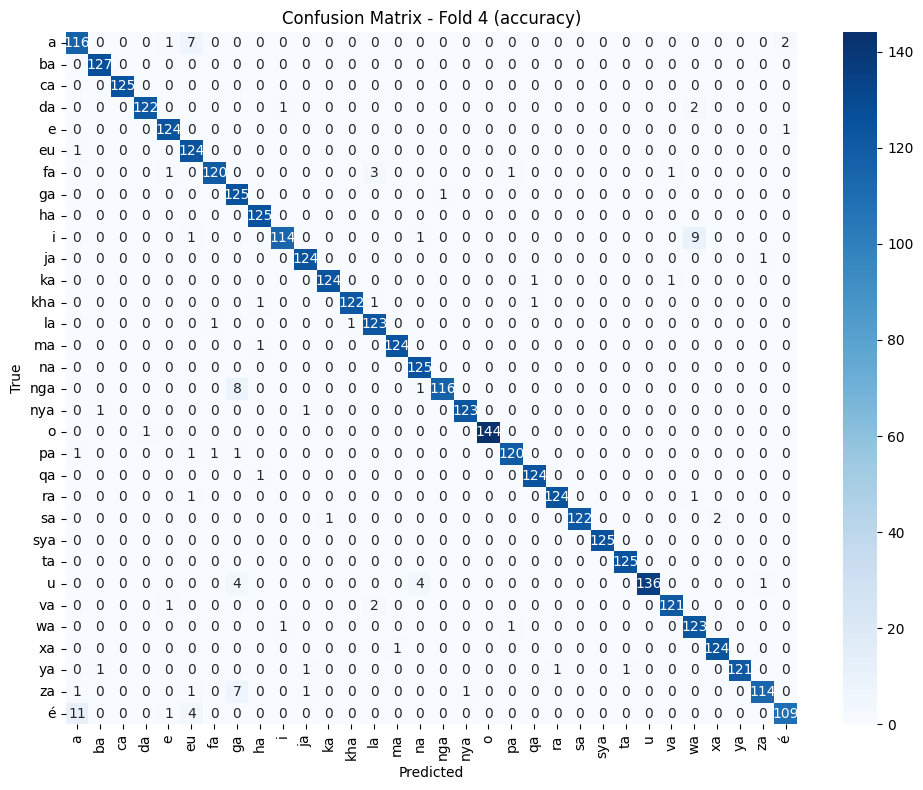


Evaluating Fold 0 - loss model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step
F1-Score: 0.9762
              precision    recall  f1-score   support

           a       0.92      0.85      0.88       126
          ba       0.98      1.00      0.99       127
          ca       0.97      0.99      0.98       125
          da       0.98      1.00      0.99       125
           e       1.00      0.99      1.00       125
          eu       0.98      0.98      0.98       125
          fa       0.94      0.99      0.97       126
          ga       0.97      0.99      0.98       126
          ha       0.98      0.98      0.98       125
           i       0.99      0.96      0.98       125
          ja       0.95      1.00      0.98       125
          ka       0.99      0.96      0.98       126
         kha       0.98      0.98      0.98       125
          la       0.94      0.98      0.96       125
          ma       1.00      0.97      0.98       125
          na       0.99      1.00      1.00       125
         nga       0.

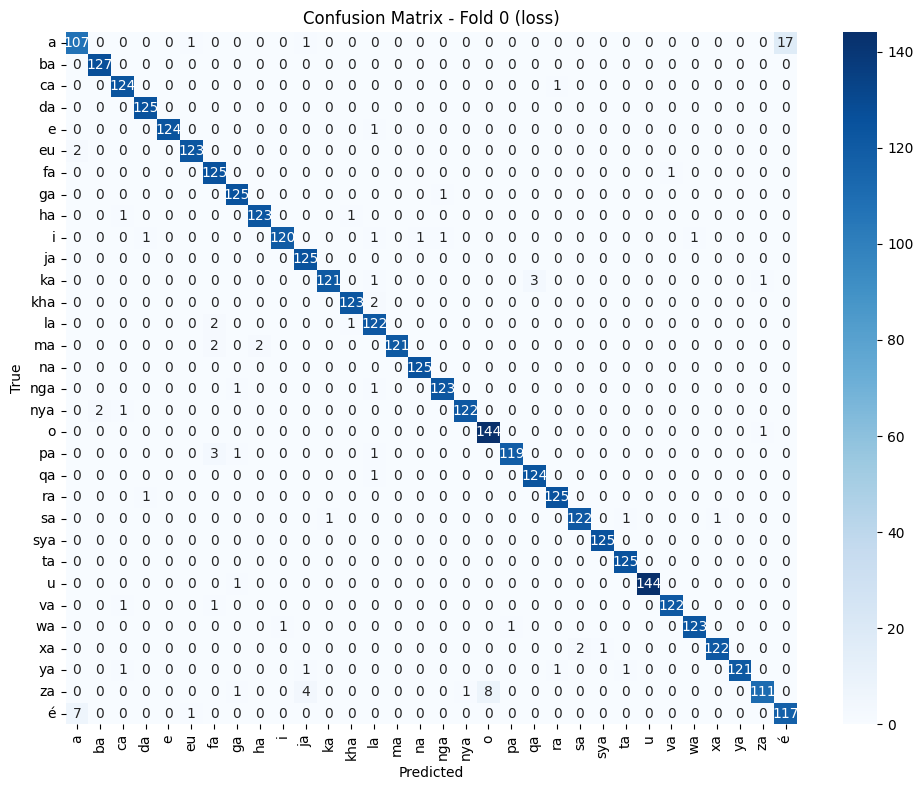


Evaluating Fold 1 - loss model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step
F1-Score: 0.9738
              precision    recall  f1-score   support

           a       0.89      0.91      0.90       126
          ba       0.98      1.00      0.99       127
          ca       1.00      0.99      1.00       125
          da       0.98      1.00      0.99       125
           e       1.00      0.98      0.99       125
          eu       0.99      0.96      0.98       125
          fa       0.93      0.97      0.95       126
          ga       0.98      0.98      0.98       126
          ha       0.99      0.99      0.99       125
           i       0.98      0.98      0.98       125
          ja       0.96      0.99      0.98       125
          ka       1.00      0.94      0.97       126
         kha       0.98      0.98      0.98       125
          la       0.99      0.98      0.99       125
          ma       1.00      0.97      0.98       125
          na       0.95      1.00      0.97       125
         nga       0.

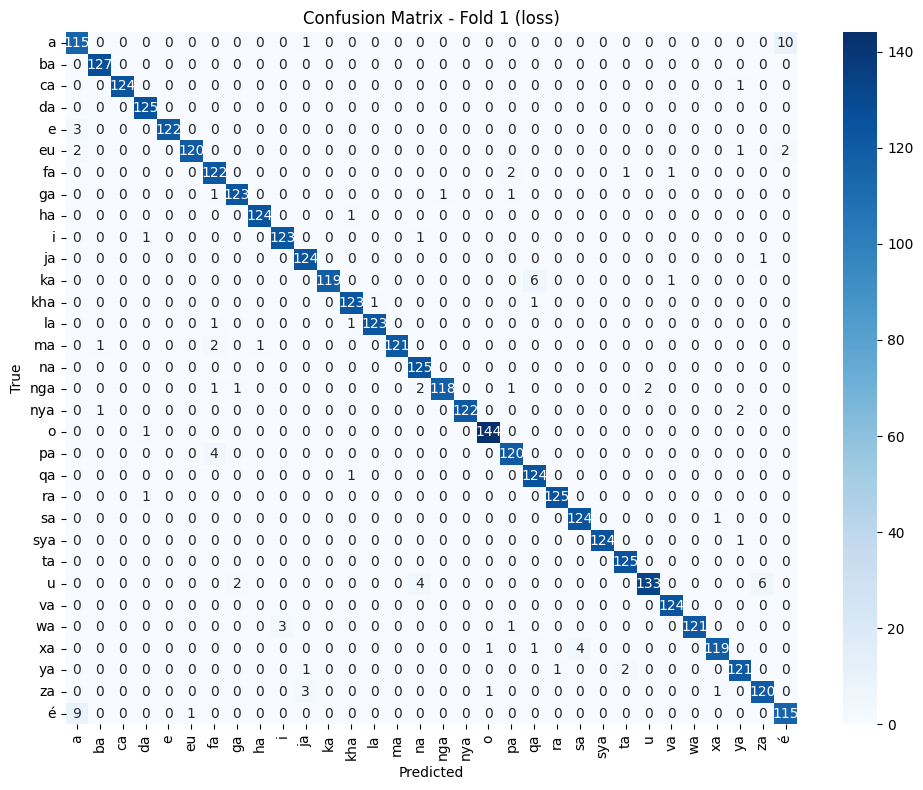


Evaluating Fold 2 - loss model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step
F1-Score: 0.9708
              precision    recall  f1-score   support

           a       0.94      0.72      0.82       126
          ba       0.99      0.98      0.99       127
          ca       1.00      0.99      1.00       125
          da       0.99      0.98      0.98       125
           e       0.97      0.99      0.98       125
          eu       0.98      0.94      0.96       125
          fa       0.89      0.98      0.94       126
          ga       0.99      0.96      0.98       126
          ha       0.98      0.99      0.99       125
           i       0.96      0.98      0.97       125
          ja       0.98      0.99      0.99       125
          ka       0.98      1.00      0.99       126
         kha       0.99      0.98      0.99       125
          la       0.99      0.92      0.95       125
          ma       1.00      0.95      0.98       125
          na       0.96      1.00      0.98       125
         nga       0.

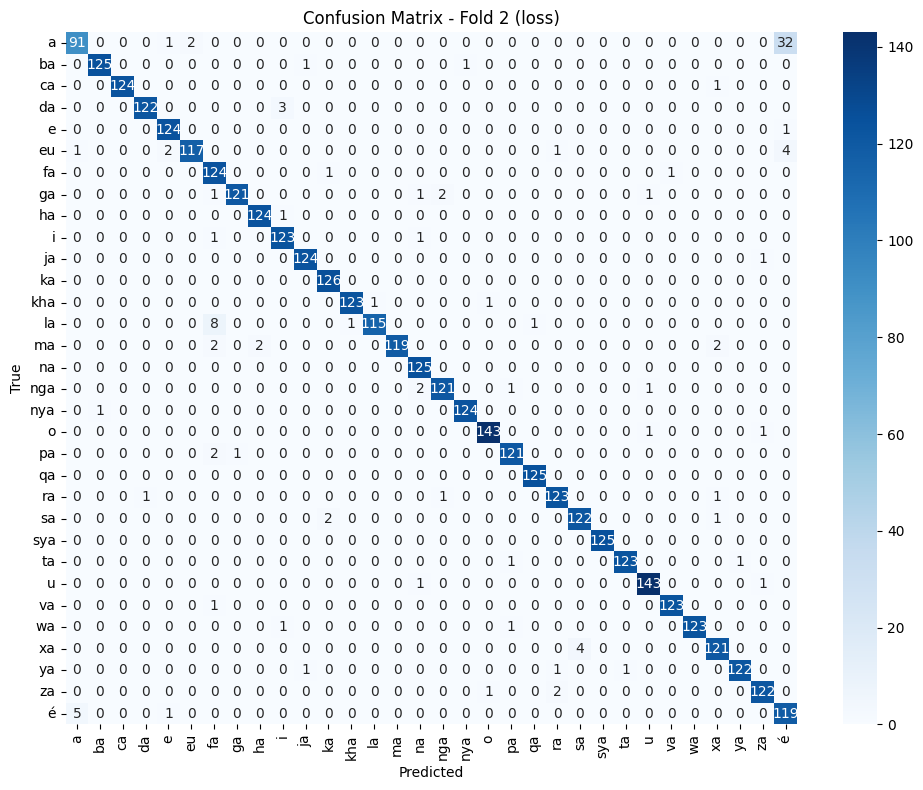


Evaluating Fold 3 - loss model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step
F1-Score: 0.9744
              precision    recall  f1-score   support

           a       0.92      0.86      0.89       126
          ba       0.99      0.98      0.99       127
          ca       0.96      1.00      0.98       125
          da       0.96      0.99      0.98       125
           e       1.00      0.93      0.96       125
          eu       1.00      0.95      0.98       125
          fa       0.94      0.98      0.96       126
          ga       0.98      0.97      0.98       126
          ha       0.99      0.96      0.98       125
           i       0.99      0.98      0.99       125
          ja       0.98      1.00      0.99       125
          ka       0.98      0.98      0.98       126
         kha       0.98      0.98      0.98       125
          la       0.98      0.96      0.97       125
          ma       0.97      0.98      0.98       125
          na       0.99      0.98      0.99       125
         nga       0.

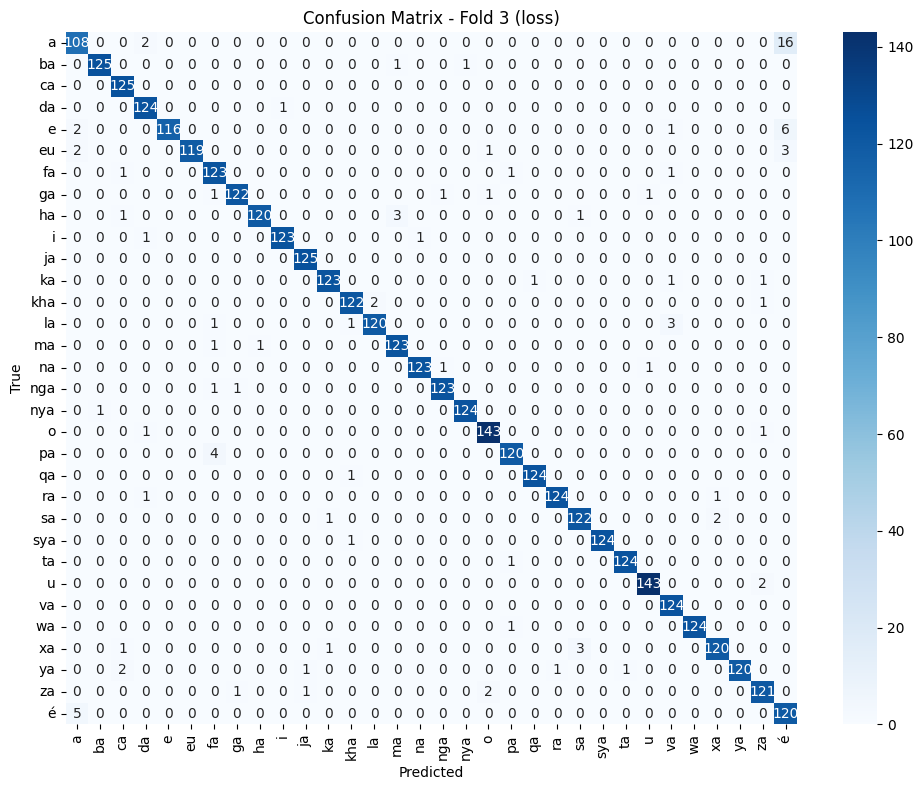


Evaluating Fold 4 - loss model...


127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step
F1-Score: 0.9732
              precision    recall  f1-score   support

           a       0.90      0.95      0.93       126
          ba       0.99      1.00      1.00       127
          ca       1.00      0.98      0.99       125
          da       1.00      0.96      0.98       125
           e       0.99      0.97      0.98       125
          eu       0.98      0.98      0.98       125
          fa       0.95      0.90      0.93       126
          ga       0.98      0.95      0.97       126
          ha       0.95      1.00      0.98       125
           i       0.91      0.98      0.95       125
          ja       0.98      0.99      0.98       125
          ka       1.00      0.97      0.98       126
         kha       0.99      0.97      0.98       125
          la       0.91      0.98      0.95       125
          ma       1.00      0.96      0.98       125
          na       0.96      1.00      0.98       125
         nga       0.

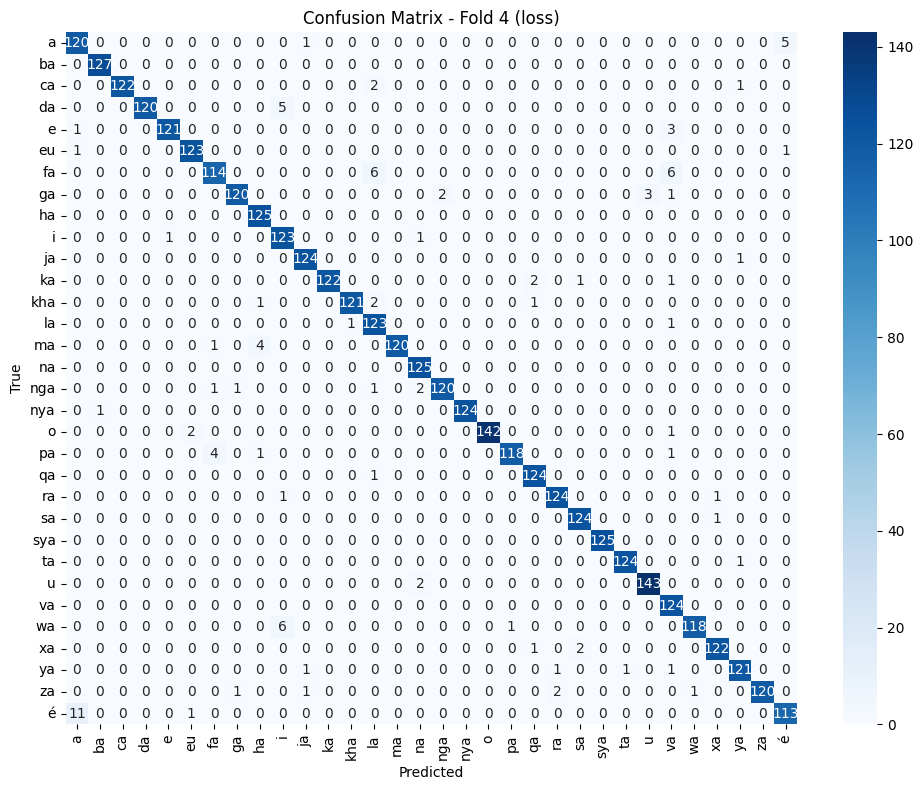

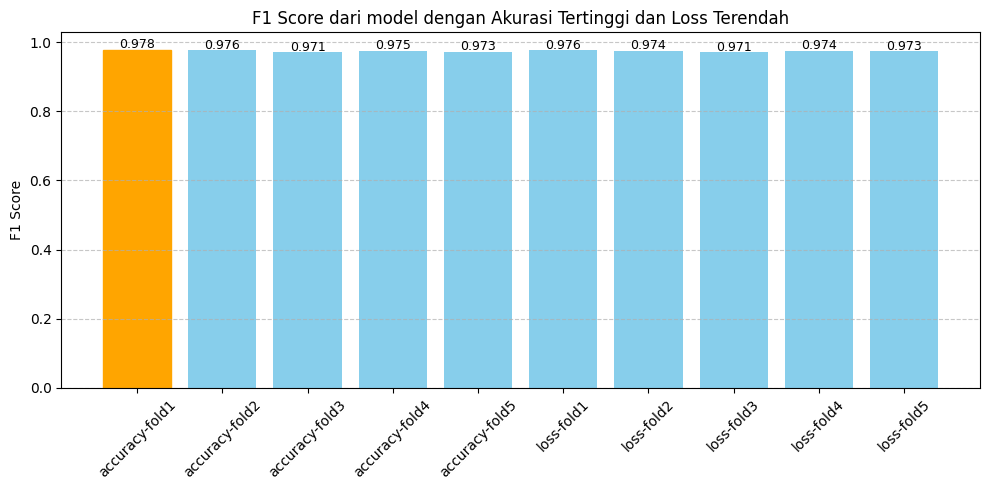


🏆 Model terbaik secara keseluruhan adalah: Fold 1 - accuracy model
📈 F1-Score: 0.9785
📁 Path: saved_model_finetune/fold_0/best_accuracy_model.h5


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Konfigurasi
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_FOLDS = 5
TEST_DIR = "Datasets/model1/validation"
CLASS_NAMES = sorted(os.listdir("Datasets/model1/training"))

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluasi seluruh model dan cari model terbaik tunggal berdasarkan F1-score
model_scores = []

for mode in ["accuracy", "loss"]:
    for fold in range(NUM_FOLDS):
        model_path = f"saved_model_finetune/fold_{fold}/best_{mode}_model.h5"
        if not os.path.exists(model_path):
            print(f"Model not found: {model_path}")
            continue

        print(f"\nEvaluating Fold {fold} - {mode} model...")
        model = load_model(model_path)
        predictions = model.predict(test_generator)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_generator.classes

        cm = confusion_matrix(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"F1-Score: {f1:.4f}")
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

        model_scores.append({
            'fold': fold + 1,
            'mode': mode,
            'f1_score': f1,
            'model_path': model_path
        })

        # Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
        plt.title(f"Confusion Matrix - Fold {fold} ({mode})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

# Visualisasi semua F1-score
fold_labels = [f"{d['mode']}-fold{d['fold']}" for d in model_scores]
f1_scores = [d['f1_score'] for d in model_scores]
max_idx = np.argmax(f1_scores)

plt.figure(figsize=(10, 5))
bars = plt.bar(fold_labels, f1_scores, color='skyblue')
bars[max_idx].set_color('orange')
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.3f}", ha='center', fontsize=9)

plt.title("F1 Score dari model dengan Akurasi Tertinggi dan Loss Terendah")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.ylim(0, max(f1_scores) + 0.05)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Tampilkan model terbaik secara keseluruhan
best_model = model_scores[max_idx]
print(f"\n🏆 Model terbaik secara keseluruhan adalah: Fold {best_model['fold']} - {best_model['mode']} model")
print(f"📈 F1-Score: {best_model['f1_score']:.4f}")
print(f"📁 Path: {best_model['model_path']}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


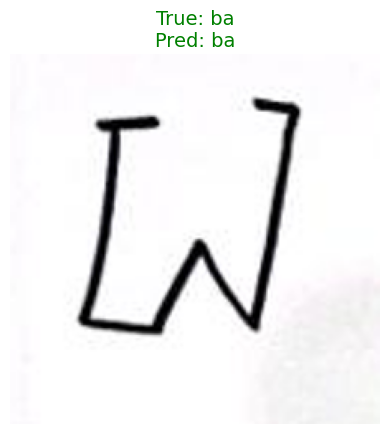

✅ Label Prediksi: ba
✅ Label Sebenarnya: ba


In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt


TRAIN_DIR = 'Datasets/model1/training'
class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
model_path = "saved_model_finetune/fold_0/best_accuracy_model.h5"

def predict_single_image(img_path, model_path, class_names, img_size=224):
    # Ambil label sebenarnya dari nama folder
    model = load_model(model_path)
    true_label = os.path.basename(os.path.dirname(img_path))

    # Load dan preproses gambar
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimensi

    # Prediksi
    pred_probs = model.predict(img_array)
    pred_index = np.argmax(pred_probs)
    predicted_label = class_names[pred_index]

    # Visualisasi hasil
    plt.imshow(img)
    plt.axis('off')
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=14)
    plt.show()

    return predicted_label, true_label

# img_path = 'Datasets/model2/validation/ayana/1.png'  
img_path = 'Datasets/model1/validation/ba/ba (1).png'  
pred, true = predict_single_image(img_path, model_path, class_names)
print("✅ Label Prediksi:", pred)
print("✅ Label Sebenarnya:", true)

